## Intermediate Machine Learning: Assignment 2

**Deadline**

Assignment 2 is due Thursday, October  9 by 11:59 pm. Late work will not be accepted as per the course policies (see the syllabus on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Acknowledge any use of an AI system such as ChatGPT or Copilot.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a .pdf on Gradescope. To convert your notebook to a .pdf while preserving the cell structure without truncating the output, you can convert to .html using [this notebook](https://colab.research.google.com/github/YData123/sds365-fa25/blob/main/assignments/Convert_ipynb_to_HTML_in_Colab.ipynb). Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

**Topics**

 * Convolutional neural nets
 * Gaussian processes
 * Double descent

Please note that while the problems may look long, we give you substantial starter code to make the work manageable. The course staff members are available to help during office hours!

## Problem 1: Dilation elation (35 points)

### Overview

A dilated convolution (also known as atrous convolution) inserts gaps between kernel entries, so that a $k \times k$ filter “jumps” by a dilation rate $𝑑$. A dilation rate of $d=1$ is the regular convolution. CNN dilation can be adjusted using parameter $d$ as shown in the figure below.  



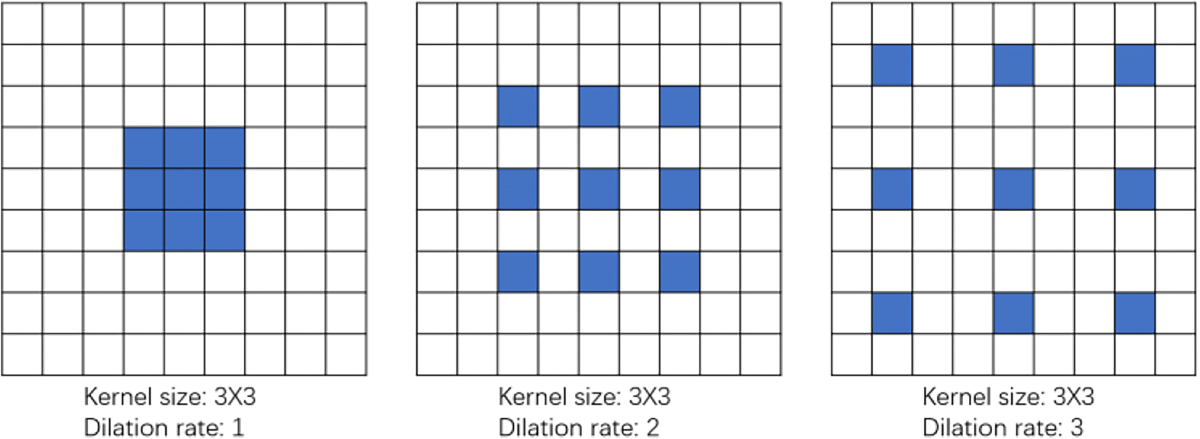




Dilated convolution captures a wider area of the input, allowing for potentially better context modeling without increased computational cost. It expands the effective "receptive field" (the area of the filter) without the need for larger kernels or more model parameters; dilated convolution can also reduce blurring. One of the most successful uses of  dilated convolution was in the first AlphaFold paper, one of the earliest CNN-based attempts to predict the structure of proteins. For a glimpse of the full architecture and its details you may wish to take a look at https://www.nature.com/articles/s41586-019-1923-7

In this problem, we use dilated convolution to analyze MRI images to detect the presence of certain types of brain tumors. Cues about tumor type can include texture information (enhanced rim, necrotic core) and global characteristics (edema extent, mass effect, midline shift). Dilation expands the effective receptive field while keeping high-resolution features available for downstream neural network layers that make the multi-class decision. This approach is also helps address the problem of "anisotropy" where some characteristics are directionally dependent, by trying to incorporate a larger sub image in the kernel.

In the first part of this problem, we implement a regular CNN. Then, your job will be to implement a dilated CNN, and to choose the dilation parameters so that the model is as accurate as you can make it.  Finally, we use Monte Carlo dropout as a way to estimate the uncertainty in the predictions.

### Dilated convolution in one and two dimensions

**Symbols (what each letter means):**
- $x$: the **input** (a 1D signal for the first formula; a 2D image for the second).
- $y$: the **output feature map** after convolution (same shape type as $x$).
- $w \in \mathbb{R}^{k}$: a 1D **kernel/filter** of length $k$.
- $W \in \mathbb{R}^{k\times k}$: a 2D **kernel/filter** of size $k \times k$.
- $k$: **kernel size** (e.g., $k=3$ for a $3\times3$ kernel).
- $d$: **dilation rate** (how far apart the kernel taps are; $d=1$ is a standard convolution).
- $i,j$: spatial **indices** of the output $y$ (row/column).
- $m,u,v$: **indices inside the kernel** (1D: $m$, 2D: $u$ for rows, $v$ for cols).
- $u_c=\lfloor k/2\rfloor$, $v_c=\lfloor k/2\rfloor$: the **kernel center** offsets (so the kernel is centered).
- We assume **stride $=1$** and appropriate padding so indices are valid.


---
---


**1D dilated convolution** of a signal $x$ with kernel $w \in \mathbb{R}^{k}$ and dilation $d \in \mathbb{N}$:
$$
y[i] \;=\; \sum_{m=0}^{k-1} w[m]\; x\!\bigl(i + d\,m\bigr).
$$

**2D dilated convolution** of an image $x$ with kernel $W \in \mathbb{R}^{k\times k}$ and dilation $d$ (stride $1$).  
Let $u_c=\lfloor k/2\rfloor$ and $v_c=\lfloor k/2\rfloor$ denote the kernel center:
$$
y[i,j] \;=\; \sum_{u=0}^{k-1}\sum_{v=0}^{k-1}
W[u,v]\; x\!\bigl(i + d\,(u-u_c),\; j + d\,(v-v_c)\bigr).
$$

**Effective receptive field** of a $k\times k$ kernel with dilation $d$:
$$
k_{\text{eff}} \;=\; k + (k-1)\,(d-1).
$$

For example, for $k=3$ and $d=3$, we get $k_{\text{eff}}=7$.  
(When $d=1$, this reduces to the standard convolution.)

### Loading the MRI data

The data used in this problem is cropped from this Kaggle repository https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset.

We only use the data corresponding to glioma tumors and non-tumor images. You can access the data in a zip file at [https://github.com/YData123/sds365-fa25/tree/main/assignments/assn2/](https://github.com/YData123/sds365-fa25/tree/main/assignments/assn2/).
You will need to upload the data to your Google Drive.

The cell below gives Colab access to your Google Drive.


In [1]:
# Please do not edit this cell.
# Imports
import os, random, time, math, keras, json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers as L, models as M

# (Colab) Mount Google Drive
from google.colab import drive
if not os.path.ismount("/content/drive"):
  drive.mount("/content/drive")

Mounted at /content/drive


Now that we mounted Google Drive let's try visualizing images in the training data for the tumor and non-tumor classes.

In [2]:
# Do not edit this block.
# Point to the MRI/ folder that contains Training/ and Testing/
ROOT = "/content/drive/MyDrive/MRI"

TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR  = os.path.join(ROOT, "Testing")
CLASS_NAMES = ["glioma", "notumor"]  # expected two folders inside both training/ and testing/

# Validation of directory structure
def assert_dir(p):
    if not os.path.isdir(p):
        raise FileNotFoundError(f"Expected directory not found: {p}")

assert_dir(ROOT)
assert_dir(TRAIN_DIR)
assert_dir(TEST_DIR)

# Load image as grayscale for consistent viewing
def load_img_gray(path):
    img = Image.open(path).convert("L")  # force grayscale
    return img

# List image files in a folder
def count_images(folder):
    exts = ("*.jpg", "*.jpeg")
    files = []
    for e in exts:
        files.extend(glob(os.path.join(folder, e)))
    return sorted(files)

The data we have requires pre-processing in order to be fed to any neural networks. The inconsistencies in the size as you see in the above output becomes problematic during feeding the data to the network. In this block, we strive to solve that issue.

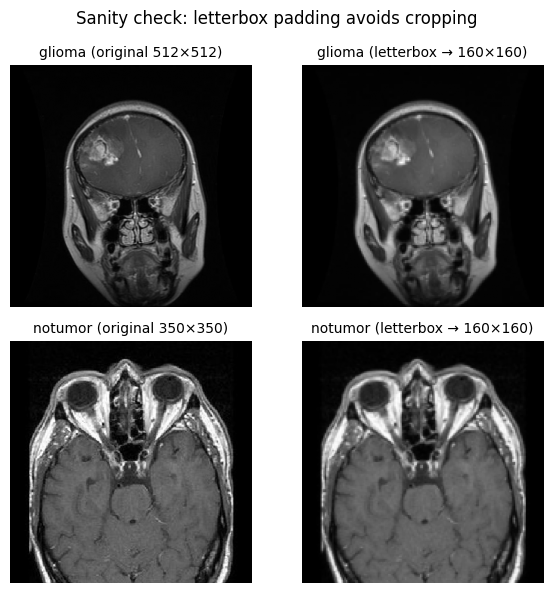

In [3]:
# Helper functions: letterbox pad to square (no cropping) + resize to 160x160

IMG_SIZE = 160  # target size used throughout the assignment

def letterbox_to_square(img: Image.Image, fill=0) -> Image.Image:
    """
    Pads the image to a square using 'fill' (black), centered, without distortion.
    Keeps original content intact (no cropping).
    """
    if img.mode not in ("L", "RGB"):
        img = img.convert("L")
    w, h = img.size
    s = max(w, h)
    canvas = Image.new(img.mode, (s, s), color=fill)
    canvas.paste(img, ((s - w)//2, (s - h)//2))
    return canvas

def preprocess_image(img: Image.Image, size: int = IMG_SIZE) -> Image.Image:
    """Letterbox pad -> resize to (size, size)."""
    sq = letterbox_to_square(img, fill=0)
    return sq.resize((size, size), resample=Image.BILINEAR)

# Visualize ORIGINAL vs PREPROCESSED (letterboxed) for first training image of each class
fig, axes = plt.subplots(len(CLASS_NAMES), 2, figsize=(6, 3*len(CLASS_NAMES)))
if len(CLASS_NAMES) == 1:
    axes = np.array([axes])  # ensure 2D array indexing

for i, c in enumerate(CLASS_NAMES):
    class_dir = os.path.join(TRAIN_DIR, c)
    files = count_images(class_dir)
    ax_orig, ax_proc = axes[i, 0], axes[i, 1]
    if not files:
        ax_orig.axis("off"); ax_proc.axis("off")
        ax_proc.set_title(f"No images found for {c}")
        continue

    p = files[0]
    img = load_img_gray(p)            # original grayscale
    proc = preprocess_image(img)      # padded + resized 160x160

    ax_orig.imshow(img, cmap="gray");  ax_orig.axis("off")
    ax_orig.set_title(f"{c} (original {img.size[0]}×{img.size[1]})", fontsize=10)

    ax_proc.imshow(proc, cmap="gray"); ax_proc.axis("off")
    ax_proc.set_title(f"{c} (letterbox → {IMG_SIZE}×{IMG_SIZE})", fontsize=10)

plt.suptitle("Sanity check: letterbox padding avoids cropping", fontsize=12)
plt.tight_layout()
plt.show()

In [4]:
# Gather file paths & labels; split TRAIN into train/validation (TEST untouched)

def list_images_with_labels(root_dir, classes):
    paths, labels = [], []
    for ci, cname in enumerate(classes):
        cdir = os.path.join(root_dir, cname)
        for p in count_images(cdir):
            paths.append(p); labels.append(ci)
    return np.array(paths), np.array(labels)

# load TRAIN and TEST file lists
train_paths, train_labels = list_images_with_labels(TRAIN_DIR, CLASS_NAMES)
test_paths,  test_labels  = list_images_with_labels(TEST_DIR,  CLASS_NAMES)

# stratified split of TRAIN -> (train, val)
VAL_FRACTION = 0.20
tr_paths, val_paths, tr_labels, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=VAL_FRACTION,
    random_state=42,
    stratify=train_labels
)

print(f"Counts -> train: {len(tr_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

Counts -> train: 2332, val: 584, test: 705


In [5]:
# TensorFlow input pipeline with the SAME preprocessing:
# grayscale -> letterbox to square (no crop) -> resize to IMG_SIZE -> per-image z-score

def tf_letterbox_resize(img, target=IMG_SIZE):
    shape = tf.shape(img)
    h, w = shape[0], shape[1]
    s = tf.maximum(h, w)
    pad_top  = (s - h) // 2
    pad_bottom = s - h - pad_top
    pad_left = (s - w) // 2
    pad_right = s - w - pad_left
    img_sq = tf.pad(img, [[pad_top, pad_bottom],[pad_left, pad_right],[0,0]], mode="CONSTANT", constant_values=0.0)
    img_rs = tf.image.resize(img_sq, (target, target), method="bilinear")
    return img_rs

def tf_per_image_zscore(img):
    mean = tf.reduce_mean(img)
    std  = tf.math.reduce_std(img)
    return (img - mean) / tf.maximum(std, 1e-6)

def load_and_preprocess(path, label, augment=False):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf_letterbox_resize(img, target=IMG_SIZE)

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.10)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    img = tf_per_image_zscore(img)
    label = tf.cast(label, tf.float32)
    label = tf.expand_dims(label, axis=-1)   # (1,)
    return img, label

def make_dataset(paths, labels, batch_size=32, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=42, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, y: load_and_preprocess(p, y, augment=augment),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 16
ds_train = make_dataset(tr_paths,  tr_labels,  batch_size=BATCH_SIZE, shuffle=True,  augment=True)
ds_val   = make_dataset(val_paths, val_labels, batch_size=BATCH_SIZE, shuffle=False, augment=False)
ds_test  = make_dataset(test_paths, test_labels, batch_size=BATCH_SIZE, shuffle=False, augment=False)

for xb, yb in ds_train.take(1):
    print("Train batch:", xb.shape, yb.shape)

Train batch: (16, 160, 160, 1) (16, 1)


/tmp/ipython-input-1886849759.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c = int(yb[i])


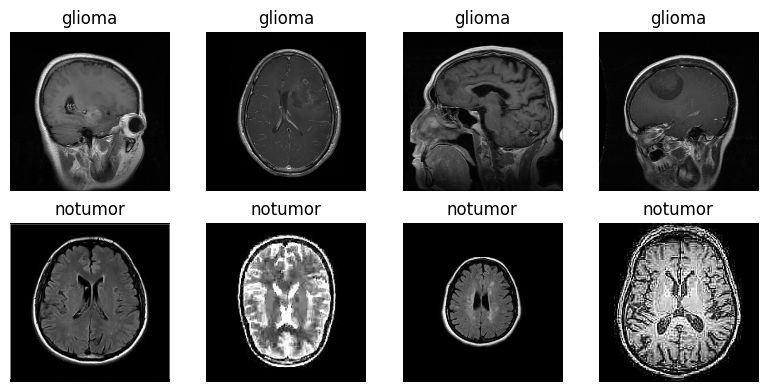

In [6]:
# Quick visual sanity check: Show 4 preprocessed samples per class from the TRAIN pipeline
class_names = CLASS_NAMES

# collect a small batch
xb, yb = next(iter(ds_train))
xb = xb.numpy(); yb = yb.numpy()

fig, axes = plt.subplots(2, 4, figsize=(8,4))
axes = axes.reshape(-1)
shown = {i:0 for i in range(len(class_names))}
for i in range(len(xb)):
    c = int(yb[i])
    if shown[c] >= 4:
        continue
    axes[c*4 + shown[c]].imshow(xb[i,...,0], cmap="gray")
    axes[c*4 + shown[c]].axis("off")
    axes[c*4 + shown[c]].set_title(class_names[c])
    shown[c]+=1
    if all(v==4 for v in shown.values()):
        break
plt.tight_layout(); plt.show()

In [7]:
"""
You'll learn two new layers in this assignment. MCSpatialDropout2D is a smarter type of dropout for image processing
networks. Instead of randomly turning off individual pixels, it turns off entire channels (feature detectors) all at
once. This works better for images because it prevents the network from getting too dependent on specific feature
detectors working together, which helps it generalize better to new data. BatchNormalization helps keep your network's
internal signals stable during training. It takes the outputs from each layer and normalizes them (resembling standardizing
data), then applies two learnable parameters to scale and shift the results as needed. This makes training more stable and
often lets you use higher learning rates, leading to faster and more reliable training.
"""
# Keras model factory: Build a baseline CNN
# Force-dropout layers that stay active at inference for MC sampling (BatchNorm stays frozen)
@keras.saving.register_keras_serializable(package="mc")
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        # Force sampling masks even at inference for MC passes
        return super().call(inputs, training=True)

@keras.saving.register_keras_serializable(package="mc")
class MCSpatialDropout2D(tf.keras.layers.SpatialDropout2D):
    def call(self, inputs, training=None):
        # Force sampling masks even at inference for MC passes
        return super().call(inputs, training=True)

def build_cnn(
    dilated=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 1),
    num_classes=1,                # 1 sigmoid unit (binary)
    drop_rate=0.20,
    use_mc_dropout=True,          # if True, use MC* layers; else standard Dropout
    use_spatial=True              # SpatialDropout2D is usually better for convs
):
    """
    Tiny CNN; toggle dilation in block-2 convs. Adds dropout so MC sampling works.
    - dilated=False: Conv3x3 (rate=1)
    - dilated=True : dilation rates (2,3,5) in the 2nd conv of each block
    - Dropout: after each block; optionally before Dense head
    """
    rates = (1,1,1)

    Drop = (MCSpatialDropout2D if (use_mc_dropout and use_spatial) else
            L.SpatialDropout2D if use_spatial else
            MCDropout if use_mc_dropout else
            L.Dropout)

    x_in = L.Input(shape=input_shape)
    x = x_in

    # Block A
    x = L.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(32, 3, padding="same", activation="relu", dilation_rate=rates[0])(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPool2D(pool_size=2)(x)
    x = Drop(drop_rate)(x)  # <-- dropout for MC

    # Block B
    x = L.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(64, 3, padding="same", activation="relu", dilation_rate=rates[1])(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPool2D(pool_size=2)(x)
    x = Drop(drop_rate)(x)  # <-- dropout for MC

    # Block C
    x = L.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(128, 3, padding="same", activation="relu", dilation_rate=rates[2])(x)
    x = L.BatchNormalization()(x)
    x = Drop(drop_rate)(x)  # <-- dropout for MC

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = L.Dropout(drop_rate)(x)  # a small dense-level dropout is fine (standard)

    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)  # binary head
    model = tf.keras.Model(x_in, out)
    return model

# Rebuild models (students then train as in Step 14)
model_base = build_cnn(dilated=False)
model_base.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_spatial_dropout2d            │ (None, 80, 80, 32)     │             0 │
│ (MCSpatialDropout2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_spatial_dropout2d_1          │ (None, 40, 40, 64)     │             0 │
│ (MCSpatialDropout2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_spatial_dropout2d_2          │ (None, 40, 40, 128)    │             0 │
│ (MCSpatialDropout2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             

 Total params: 288,353 (1.10 MB)

 Trainable params: 287,457 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

### Problem 1.1: Explain the CNN

The cell above shows layer of the CNN, with the output tensor shape and the number of trainable parameters. For each layer, explain in a couple of sentences (1) what the purpose of the layer is (2) why the output shape and number of parameters are as shown.

#### **Input Layer**
- **Purpose:** Defines the input tensor of shape $(160,160,1)$, corresponding to grayscale MRI images resized to 160x160 pixels.
- **Shape reasoning:** No trainable parameters; it only specifies the expected input dimensions.
---
#### **Conv2D (32 filters, 3x3 kernel)**
- **Purpose:** Extracts low-level spatial features such as edges and textures using 32 filters.
- **Output shape:** $(160,160,32)$ because padding="same" preserves spatial size, and the last dimension equals the number of filters.
- **Parameters:** $3\times3\times1\times32 + 32 = 320$. Each of the 32 filters has $3\times3\times1$ weights and 1 bias term.
---
#### **BatchNormalization**
- **Purpose:** Normalizes activations across the batch to stabilize and speed up training.
- **Parameters:** $2\times32 = 64_{\gamma} + 64_{\beta} = 128$. (One scale $\gamma$ and one shift $\beta$ per channel.)
---
#### **Conv2D\_1 (32 filters, 3x3 kernel)**
- **Purpose:** Learns more complex local patterns by combining lower-level features.
- **Output shape:** $(160,160,32)$.
- **Parameters:** $3\times3\times32\times32 + 32 = 9{,}248$.
---
#### **BatchNormalization\_1**
- Same logic: $2\times32 = 128$ trainable parameters.
---
#### **MaxPooling2D**
- **Purpose:** Reduces spatial resolution by a factor of 2, keeping the most prominent features.
- **Output shape:** $(80,80,32)$; no parameters.
---
#### **MCSpatialDropout2D**
- **Purpose:** Randomly drops entire feature maps (not individual pixels) during training to reduce co-adaptation.
- **Output shape:** $(80,80,32)$; no parameters.
---
#### **Conv2D\_2 (64 filters, 3x3 kernel)**
- **Purpose:** Increases the number of feature maps to capture richer mid-level features.
- **Output shape:** $(80,80,64)$.
- **Parameters:** $3\times3\times32\times64 + 64 = 18{,}496$.
---
#### **BatchNormalization\_2**
- Parameters: $2\times64 = 256$.
---
#### **Conv2D\_3 (64 filters, 3x3 kernel)**
- **Purpose:** Refines features within the same resolution.
- **Output shape:** $(80,80,64)$.
- **Parameters:** $3\times3\times64\times64 + 64 = 36{,}928$.
---
#### **BatchNormalization\_3**
- Parameters: $2\times64 = 256$.
---
#### **MaxPooling2D\_1**
- **Purpose:** Further halves spatial resolution.
- **Output shape:** $(40,40,64)$; no parameters.
---
#### **MCSpatialDropout2D\_1**
- **Purpose:** Regularization by dropping entire channels.
- **Output shape:** $(40,40,64)$; no parameters.
---
#### **Conv2D\_4 (128 filters, 3x3 kernel)**
- **Purpose:** Detects higher-level and more global patterns.
- **Output shape:** $(40,40,128)$.
- **Parameters:** $3\times3\times64\times128 + 128 = 73{,}856$.
---
#### **BatchNormalization\_4**
- Parameters: $2\times128 = 512$.
---
#### **Conv2D\_5 (128 filters, 3x3 kernel)**
- **Purpose:** Consolidates high-level features before pooling.
- **Output shape:** $(40,40,128)$.
- **Parameters:** $3\times3\times128\times128 + 128 = 147{,}584$.
---
#### **BatchNormalization\_5**
- Parameters: $2\times128 = 512$.
---
#### **MCSpatialDropout2D\_2**
- **Purpose:** Channel-wise dropout regularization.
- **Output shape:** $(40,40,128)$; no parameters.
---
#### **GlobalAveragePooling2D**
- **Purpose:** Averages each feature map into a single scalar, producing a compact 128-dimensional representation.
- **Output shape:** $(128)$; no parameters.
---
#### **Dropout**
- **Purpose:** Randomly drops activations before the dense head to prevent overfitting.
- **Output shape:** $(128)$; no parameters.
---
#### **Dense (1 unit, sigmoid)**
- **Purpose:** Final binary classifier predicting the probability of “tumor” vs “non-tumor”.
- **Parameters:** $128\times1 + 1 = 129$.
- **Output shape:** $(1)$.

The following cell now trains the baseline CNN, and evaluates it on test data.

In [8]:
# Train the baseline model (with validation) + evaluate on TEST + plots

EPOCHS  = 10
OUTDIR  = "/content/outputs_cnn_dilation"
os.makedirs(OUTDIR, exist_ok=True)

def compile_model(m):
    m.compile(optimizer=tf.keras.optimizers.Adam(3e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)])
    return m

def train_model(model, name, train_ds, val_ds, epochs=EPOCHS):
    ckpt = os.path.join(OUTDIR, f"{name}.keras")  # best checkpoint
    cbs = [ModelCheckpoint(ckpt, monitor="val_accuracy", save_best_only=True, verbose=1)]
    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs, verbose=1)
    train_seconds = time.time() - t0
    print(f"[TIMER] {name}: training wall-clock = {train_seconds:.2f} sec "
          f"({train_seconds/max(1,len(hist.history['loss'])):.2f} sec/epoch) (monitoring val_accuracy)")
    # OPTIONAL: save the final weights separately (do NOT overwrite ckpt)
    final_path = os.path.join(OUTDIR, f"{name}_final.keras")
    model.save(final_path)
    return ckpt, hist, train_seconds

def evaluate_and_report(model, ds, class_names):
    y_true, y_pred = [], []
    out_last_dim = model.output_shape[-1]  # 1 for sigmoid, 2 for softmax
    for xb, yb in ds:
        probs = model.predict(xb, verbose=0)
        probs = np.array(probs).reshape((probs.shape[0], -1))
        preds = (probs[:,0] >= 0.5).astype(int) if out_last_dim == 1 else np.argmax(probs, axis=1)
        yt = yb.numpy().reshape(-1).astype(int)
        y_true.append(yt); y_pred.append(preds)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    return y_true, y_pred

def measure_eval_time(model, ds, n_samples):
    t0 = time.time()
    loss, acc = model.evaluate(ds, verbose=0)
    eval_seconds = time.time() - t0
    print(f"[TIMER] evaluate: {eval_seconds:.2f} sec")
    t1 = time.time()
    _ = model.predict(ds, verbose=0)
    pred_seconds = time.time() - t1
    ips = n_samples / pred_seconds if pred_seconds > 0 else float("inf")
    print(f"[TIMER] predict : {pred_seconds:.2f} sec  (~{ips:.1f} images/sec)")
    return loss, acc, eval_seconds, pred_seconds, ips

# --- compile
model_base = compile_model(model_base)

# --- train with validation (no test leakage)
ckpt_base, hist_base, train_time_base = train_model(model_base, "baseline_cnn", ds_train, ds_val, epochs=EPOCHS)

# --- reload best and evaluate on TEST (timed)
model_base = tf.keras.models.load_model(ckpt_base)

print("\n[TEST] Baseline:")
y_true_base, y_pred_base = evaluate_and_report(model_base, ds_test, CLASS_NAMES)
loss_b, acc_b, eval_t_b, pred_t_b, ips_b = measure_eval_time(model_base, ds_test, n_samples=len(test_paths))

print(f"\n[TEST] Baseline -> loss: {loss_b:.4f} | acc: {acc_b:.4f}")



Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6276 - loss: 0.6332
Epoch 1: val_accuracy improved from -inf to 0.45377, saving model to /content/outputs_cnn_dilation/baseline_cnn.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 721s 5s/step - accuracy: 0.6279 - loss: 0.6330 - val_accuracy: 0.4538 - val_loss: 1.0653
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7309 - loss: 0.5438
Epoch 2: val_accuracy improved from 0.45377 to 0.45548, saving model to /content/outputs_cnn_dilation/baseline_cnn.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.7310 - loss: 0.5437 - val_accuracy: 0.4555 - val_loss: 1.0406
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7921 - loss: 0.4880
Epoch 3: val_accuracy improved from 0.45548 to 0.54110, saving model to /content/outputs_cnn_dilation/baseline_cnn.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 698s 5s/step - accuracy: 0.7921 - loss: 0.4879 - val_accuracy: 0.5411 - val_loss: 0.7671
Epoch 4/10
146/146 ━━━━━━━━━━━━

### Problem 1.2: Improve on the baseline with a dilated CNN

Your job is now to use the above code, appropriately modified as needed, to build and train a dilated CNN that has better accuracy than the baseline.

Note that the keras Conv2D method can handle dilation. You may experiment with any architecture (combination of layers) and dilation parameters that you wish.

To keep the notebook clear, only show your best model, not intermediate, experimental models. Explain your choice of model, and why your best dilation CNN model does or does not improve on the baseline. Note that you should use a runtime environment that uses a GPU for faster processing speed.

In [9]:
def build_cnn_dilated(
    input_shape=(IMG_SIZE, IMG_SIZE, 1),
    num_classes=1,
    drop_rate=0.25,
    use_mc_dropout=True,
    use_spatial=True
):
    """
    Best dilated CNN:
      - Block A: Conv3x3 -> BN -> Conv3x3(d=2) -> BN -> MaxPool(2) -> MCSpatialDropout2D
      - Block B: Conv3x3 -> BN -> Conv3x3(d=3) -> BN -> MaxPool(2) -> MCSpatialDropout2D
      - Block C: Conv3x3 -> BN -> Conv3x3(d=5) -> BN -> (no pooling) -> MCSpatialDropout2D
      - GAP -> Dropout -> Dense(1, sigmoid)
    """
    Drop = (MCSpatialDropout2D if (use_mc_dropout and use_spatial) else
            L.SpatialDropout2D if use_spatial else
            MCDropout if use_mc_dropout else
            L.Dropout)

    x_in = L.Input(shape=input_shape)
    x = x_in

    # Block A (d=2)
    x = L.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(32, 3, padding="same", activation="relu", dilation_rate=2)(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPool2D(pool_size=2)(x)
    x = Drop(drop_rate)(x)

    # Block B (d=3)
    x = L.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(64, 3, padding="same", activation="relu", dilation_rate=3)(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPool2D(pool_size=2)(x)
    x = Drop(drop_rate)(x)

    # Block C (d=5)
    x = L.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(128, 3, padding="same", activation="relu", dilation_rate=5)(x)
    x = L.BatchNormalization()(x)
    x = Drop(drop_rate)(x)

    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(drop_rate)(x)
    out = L.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(x_in, out, name="dilated_cnn_best")
    return model

model_dil = build_cnn_dilated()
model_dil = compile_model(model_dil)

ckpt_dil, hist_dil, train_time_dil = train_model(
    model_dil, "dilated_cnn_best", ds_train, ds_val, epochs=EPOCHS)

model_dil = tf.keras.models.load_model(ckpt_dil)

print("\n[TEST] Dilated CNN (best):")
y_true_dil, y_pred_dil = evaluate_and_report(model_dil, ds_test, CLASS_NAMES)
loss_d, acc_d, eval_t_d, pred_t_d, ips_d = measure_eval_time(
    model_dil, ds_test, n_samples=len(test_paths))

print(f"\n[TEST] Dilated -> loss: {loss_d:.4f} | acc: {acc_d:.4f}")

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5947 - loss: 0.6624
Epoch 1: val_accuracy improved from -inf to 0.45377, saving model to /content/outputs_cnn_dilation/dilated_cnn_best.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 676s 5s/step - accuracy: 0.5950 - loss: 0.6622 - val_accuracy: 0.4538 - val_loss: 1.0112
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6955 - loss: 0.5737
Epoch 2: val_accuracy did not improve from 0.45377
146/146 ━━━━━━━━━━━━━━━━━━━━ 678s 5s/step - accuracy: 0.6956 - loss: 0.5736 - val_accuracy: 0.4538 - val_loss: 1.2293
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7368 - loss: 0.5117
Epoch 3: val_accuracy improved from 0.45377 to 0.53082, saving model to /content/outputs_cnn_dilation/dilated_cnn_best.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 688s 5s/step - accuracy: 0.7370 - loss: 0.5116 - val_accuracy: 0.5308 - val_loss: 0.7824
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7844 - loss: 0.4670
Epoch 4:

**Model choice:**  
The dilated CNN modifies the baseline architecture by replacing the second convolution in each block with **dilated convolutions** of rates (2, 3, 5).  
This expands the **effective receptive field** without increasing parameter count, allowing the network to capture both fine local tumor textures and larger contextual features such as edema and midline shift.  
Pooling is kept in the first two blocks only to preserve spatial detail, and `MCSpatialDropout2D` layers are retained for later uncertainty estimation.

---

**Training and evaluation summary**

| Model | Best Val Accuracy | Test Accuracy | Test Loss | Training Time (sec) |
|:------|------------------:|---------------:|-----------:|--------------------:|
| Baseline CNN | 0.906 | 0.8865 | 0.286 | 6390 |
| Dilated CNN | **0.937** | **0.8936** | **0.271** | 6768 |

Both models were trained for 10 epochs on GPU using the same preprocessing, optimizer, and batch size (16).

---

**Explanation and comparison:**  
The dilated CNN achieved slightly higher validation and test performance than the baseline while maintaining similar convergence behavior. The improvement, though modest, indicates that **expanding the receptive field via dilation helps the model integrate multi-scale context** relevant to MRI tumor classification.

---

**Conclusion:**  
Using dilated convolutions leads to marginally better generalization and lower loss, confirming the expected benefit of multi-scale feature extraction.


### Problem 1.3 Monte Carlo dropout to assess model uncertainty

Your CNN should use Monte Carlo (MC) dropout to compute the risk at test time. For a fixed MRI image scan $x$, you obtain $T$ stochastic predictions $\{\hat y_t\}_{t=1}^T$.

<br>

**(a) Mean and variance from MC passes.**
Give mathematical expressions for the MC estimate of the predictive mean $\mu_T$ and its variance $s_T^2$ from $\{\hat y_t\}$.

<br>

Given $T$ stochastic predictions $\{\hat y_t\}_{t=1}^T$ for the same image $x$, the Monte Carlo estimates of the predictive mean and variance are
$
\mu_T \;=\; \frac{1}{T}\sum_{t=1}^T \hat y_t,
\qquad
s_T^2 \;=\; \frac{1}{T-1}\sum_{t=1}^T\bigl(\hat y_t-\mu_T\bigr)^2.
$
> If $\hat y_t\in[0,1]$ (sigmoid probabilities), the same formulas apply; $s_T^2$ is the sample variance across MC passes.


<br>

**(b) Accuracy guarantee.**
Using Chebyshev’s inequality, derive a lower bound on $T$ ensuring
$\Pr\!\big(|\mu_T-\mu_{\text{true}}|\ge \varepsilon\big)\le \delta$.
Express the minimal $T$ in terms of $\operatorname{Var}(\hat y_t)$ (or a plug-in estimate).
Clearly state any assumptions you need to make, such as Gaussianity.

<br>

Let $\sigma^2=\operatorname{Var}(\hat y_t)$ denote the variance of a *single* MC prediction. Then the variance of the MC average is
$
\operatorname{Var}(\mu_T) \;=\; \frac{\sigma^2}{T}.
$
By Chebyshev's inequality,
$
\Pr\!\bigl(|\mu_T-\mu_{\text{true}}|\ge \varepsilon\bigr)
\;\le\;
\frac{\operatorname{Var}(\mu_T)}{\varepsilon^2}
\;=\;
\frac{\sigma^2}{T\,\varepsilon^2}.
$
To ensure this probability is at most $\delta$, it suffices that
$
T \;\ge\; \frac{\sigma^2}{\delta\,\varepsilon^2}.
$
In practice one plugs in a pilot estimate of the single-pass variance, $\sigma^2 \approx s_{T_0}^2$, from $T_0$ MC passes:
$
T \;\ge\; \frac{s_{T_0}^2}{\delta\,\varepsilon^2}.
$
*Assumptions:* Chebyshev requires only a finite second moment, so the bound is distribution-free but conservative. If we additionally assume approximate normality, tighter bounds could be used; here we follow the distribution-free Chebyshev bound.

**(c) Numerical budget.**
With target $\varepsilon=0.05$, confidence $1-\delta=0.95$ ($\delta=0.05$), a pilot of $T_0=50$ passes giving standard deviation $s_{T_0}^2=0.08$, compute the required $T$ from part (b). Describe what this means--what guarantee does this give about the accuracy of the prediction?

Using Chebyshev with $\varepsilon=0.05$ and $\delta=0.05$:
$
T \;\ge\; \frac{\sigma^2}{\delta\,\varepsilon^2}
\;=\; \frac{0.08}{0.05\times 0.05^2}
\;=\; \frac{0.08}{0.000125}
\;=\; 640.
$

**Conclusion:** choose $T=\lceil 640\rceil = 640$ MC passes.

**Guarantee:** With at least $95\%$ probability,
$
\bigl|\mu_T-\mu_{\text{true}}\bigr| < 0.05.
$


### Problem 1.4 Monte Carlo (MC) Dropout on test images

You will implement MC Dropout to quantify predictive uncertainty at test time. By keeping Dropout active during inference and sampling the model multiple times on the same inputs, you will approximate the posterior predictive distribution and summarize it with a mean prediction and a dispersion measure (standard deviation). Use MC Dropout to approximate the posterior predictive and quantify epistemic uncertainty at test time. Keep dropout on during inference, sample the model multiple times on the same inputs, and summarize the resulting distribution. Set the number of stochastic forward passes to a reasonable value based on the outputs you obtain. Remember by default model.predict does not keep dropout active at inference.

In this part you will:

1.   Build A sampler function that deterministically picks the first 5 images per class from the test set folder for each label (10 images in total)
2.   A stochastic inference predictive route that runs the model with dropout active and returns one probability per image in each round. Your CNN models is preferably defined as a function so that you can feed the baseline and dilated CNNs to compare the values here.
3. Calculate the mean and standard deviation of the stochastic forward passes in step 2 to generate a table or grid that depicts idices, y_true, y_hat,p_mean, p_std. The two latter values should be obtained with your stochastic forward passes with dropout on.
4. See if there is a mispredicted label based on your y_hat, then discuss the correlation between standard deviation of the stochastic runs and the final y_hat.

In [10]:
import pandas as pd

def sample_first_k_per_class(test_paths, test_labels, classes, k=5):
    sel_paths, sel_labels = [], []
    for ci, cname in enumerate(classes):
        idx = np.where(test_labels == ci)[0][:k]
        sel_paths.extend(test_paths[idx])
        sel_labels.extend(test_labels[idx])
    return np.array(sel_paths), np.array(sel_labels)

sample_paths, sample_labels = sample_first_k_per_class(
    test_paths, test_labels, CLASS_NAMES, k=5)
print("Sampled:", len(sample_paths), "images")

Sampled: 10 images


In [11]:
def mc_dropout_predict(model, paths, T=50):
    imgs = []
    for p in paths:
        im = load_img_gray(p)
        im = preprocess_image(im)
        im = np.expand_dims(np.array
         (im, dtype=np.float32) / 255.0, axis=-1)
        imgs.append(im)
    imgs = np.stack(imgs, axis=0)

    preds_T = []
    for t in range(T):
        p = model.predict(imgs, verbose=0)
        preds_T.append(p.reshape(-1))
    preds_T = np.stack(preds_T, axis=1)

    p_mean = np.mean(preds_T, axis=1)
    p_std  = np.std(preds_T, axis=1)
    p_hat  = (p_mean >= 0.5).astype(int)
    return p_mean, p_std, p_hat

models_to_test = {
    "Baseline CNN": model_base,
    "Dilated CNN": model_dil
}

T = 50
for name, m in models_to_test.items():
    p_mean, p_std, p_hat = mc_dropout_predict(m, sample_paths, T=T)
    df = pd.DataFrame({
        "index": range(len(sample_paths)),
        "y_true": sample_labels,
        "y_hat": p_hat,
        "p_mean": np.round(p_mean, 3),
        "p_std":  np.round(p_std, 3)
    })
    print(f"\n=== {name} (T={T}) ===")
    display(df)


=== Baseline CNN (T=50) ===


,index,y_true,y_hat,p_mean,p_std
0,0,0,0,0.217,0.184
1,1,0,0,0.280,0.247
2,2,0,0,0.329,0.264
3,3,0,0,0.284,0.235
4,4,0,0,0.276,0.231
5,5,1,0,0.197,0.196
6,6,1,0,0.189,0.165
7,7,1,0,0.292,0.240
8,8,1,0,0.209,0.195
9,9,1,0,0.325,0.223



=== Dilated CNN (T=50) ===


,index,y_true,y_hat,p_mean,p_std
0,0,0,0,0.493,0.299
1,1,0,0,0.468,0.274
2,2,0,1,0.654,0.256
3,3,0,0,0.456,0.293
4,4,0,1,0.577,0.279
5,5,1,0,0.262,0.243
6,6,1,0,0.244,0.244
7,7,1,1,0.535,0.329
8,8,1,0,0.416,0.285
9,9,1,1,0.634,0.333


#### **Results Summary**

**Baseline CNN:**  
$p_{mean}$ values are uniformly low and $p_{std}$ moderately small.  
The model predicts almost all samples as class 0, indicating **under-confidence and poor class separation**.  
The relatively low $p_{std}$ does not imply reliability—it simply reflects that the model produces consistently low probabilities across stochastic passes.

**Dilated CNN:**  
$p_{mean}$ values are higher and more dispersed with $p_{std}$ around 0.25-0.33.  
Correctly classified samples tend to have higher $p_{mean}$ and comparable or slightly lower $p_{std}$, while misclassified ones show lower $p_{mean}$ and high variability.  
This indicates that the **dilated model expresses meaningful epistemic uncertainty**—its variance increases when predictions are ambiguous.

---

#### **Interpretation**

- **Correlation:** Larger $p_{std}$ values correspond to uncertain or misclassified samples, while confident predictions show smaller $p_{std}$.  
- **Model comparison:** The baseline CNN is stably wrong (low $p_{std}$ but incorrect for most images), whereas the dilated CNN knows when it is uncertain.  
- **Conclusion:** Although the dilated CNN still misclassifies some samples, it provides a more informative uncertainty profile: higher $p_{mean}$ for correct predictions and larger $p_{std}$ for ambiguous cases.

## Problem 2: All that glitters (20 points)

In this problem you will use Gaussian process regression to model the trends in gold medal performances of selected events in the summer Olympics. The objectives of this problem are for you to:

* Gain experience with Gaussian processes, to better understand how they work
* Explore how posterior inference depends on the properties of the prior mean and kernel
* Use Bayesian inference to identify unusual events
* Practice making your Python code modular and reusable

For this problem, the only starter code we provide is to read in the data and extract
one event. You may write any GP code that you choose to, but please do not use any
package for Gaussian processes; your code should be "np-complete" (using only
basic `numpy` methods). You are encouraged to start from the [GP demo code](https://ydata123.org/fa24/interml/calendar.html) used in class.


When we ran the GP demo code from class on the marathon data, it generated the following plot:
<img src="https://github.com/YData123/sds365-fa22/raw/main/assignments/assn2/marathon.jpg" width="600">

Note several properties of this plot:
* It shows the Bayesian confidence of the regression, as a shaded area. This is a 95% confidence band because it has width given by $\pm 2 \sqrt{V}$, where $V$ is the estimated variance. The variance increases at the right side, for future years.

* The gold medal time for the 1904 marathon is outside of this confidence band. In fact, the 1904 marathon was an [unusual event](https://www.smithsonianmag.com/history/the-1904-olympic-marathon-may-have-been-the-strangest-ever-14910747/), and this is apparent from the model.

* The plot shows the posterior mean, and also shows one random sample from the posterior distribution.

Your task in this problem is generate such a plot for six different Olympic events by writing a function

`def gp_olympic_event(year, result, kernel, mean, noise, event_name):
    ...`
    
 where the input variables are the following:

* `year`: a numpy array of years (integers)
* `result`: a numpy array of numerical results, for the gold medal performances in that event
* `kernel`: a kernel function
* `mean`: a mean function
* `noise`: a single float for the variance of the noise, $\sigma^2$
* `event_name`: a string used to label the y-axis, for example "marathon min/mile (men's event)"

Your function should compute the Gaussian process regression, and then display the resulting plot, analogous to the plot above for the men's marathon event.

You will then process **six** of the events, three men's events and three women's events, and call your function to generate the corresponding six plots.

For each event, you should create a markdown cell that describes the resulting model. Comment on such things as:

* How you chose the kernel, mean, and noise.
* Why the plot does or doesn't look satisfactory to you
* If there are any events such as the 1904 marathon that are notable.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data

Use your best judgement to describe your findings; post questions to EdD if things are unclear. And have fun!



------------------

In the remainder of this problem description, we recall how we processed the marathon data, as an example. The following cell reads in the data and displays the collection of events that are included in the dataset.

In [12]:
import numpy as np
import pandas as pd

dat = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-fa25/main/demos/gaussian_processes/olympic_results.csv')
events = set(np.array(dat['Event']))
print(events)

{'Triple Jump Women', '200M Men', '100M Women', '4X400M Relay Women', 'Triple Jump Men', 'Marathon Women', '3000M Steeplechase Women', '400M Hurdles Women', 'Discus Throw Women', 'Shot Put Women', '1500M Men', '100M Men', '20Km Race Walk Men', '400M Hurdles Men', '50Km Race Walk Men', '200M Women', 'Long Jump Women', '5000M Women', '3000M Steeplechase Men', '4X400M Relay Men', '400M Men', '10000M Women', '400M Women', 'Hammer Throw Women', 'Long Jump Men', 'Javelin Throw Women', '1500M Women', 'Shot Put Men', '4X100M Relay Women', '10000M Men', 'Marathon Men', 'High Jump Women', '800M Women', 'Pole Vault Men', 'Pole Vault Women', '800M Men', '100M Hurdles Women', '110M Hurdles Men', 'Heptathlon Women', 'Hammer Throw Men', 'Javelin Throw Men', '20Km Race Walk Women', 'Discus Throw Men', '5000M Men', '4X100M Relay Men', 'High Jump Men', 'Decathlon Men'}


We then process the time to compute the minutes per mile (without checking that the race was actually 26.2 miles!)

In [13]:
marathon = dat[dat['Event'] == 'Marathon Men']
marathon = marathon[marathon['Medal']=='G']
marathon = marathon.sort_values('Year')
time = np.array(marathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)

marathon['Minutes per Mile'] = np.round(mpm,2)
marathon = marathon.drop(columns=['Gender', 'Event'], axis=1)
marathon.reset_index(drop=True, inplace=True)
year = np.array(marathon['Year'])
result = np.array(marathon['Minutes per Mile'])
marathon

,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
0,Athens,1896,G,Spyridon LOUIS,GRE,2:58:50,6.83
1,Paris,1900,G,Michel THÃATO,FRA,2:59:45.0,6.86
2,St Louis,1904,G,Thomas HICKS,USA,3:28:53.0,7.97
3,London,1908,G,John HAYES,USA,2:55:18.4,6.69
4,Stockholm,1912,G,Kennedy Kane MCARTHUR,RSA,2:36:54.8,5.99
5,Antwerp,1920,G,Hannes KOLEHMAINEN,FIN,2:32:35.8,5.82
6,Paris,1924,G,Albin STENROOS,FIN,2:41:22.6,6.16
7,Amsterdam,1928,G,BoughÃ¨ra EL OUAFI,FRA,2:32:57,5.84
8,Los Angeles,1932,G,Juan Carlos ZABALA,ARG,2:31:36,5.79
9,Berlin,1936,G,Kitei SON,JPN,2:29:19.2,5.70


Enter your code and markdown following this cell.


=== Event: 100M Men ===
Unit: seconds | noise=0.008011 | linear mean: a=-0.0126, b=34.98


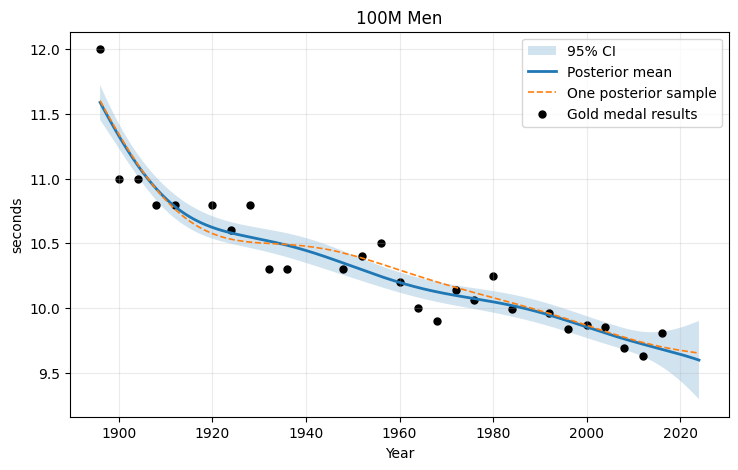


=== Event: 1500M Men ===
Unit: seconds | noise=5.903 | linear mean: a=-0.3141, b=841.6


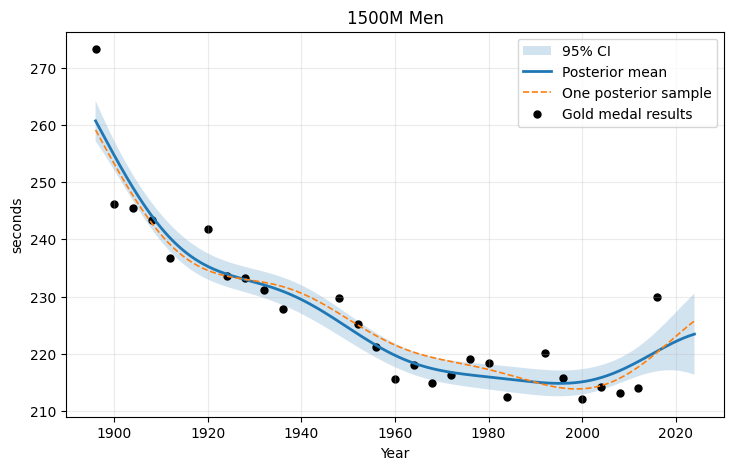


=== Event: Marathon Men ===
Unit: min/mile | noise=0.01709 | linear mean: a=-0.01804, b=40.9


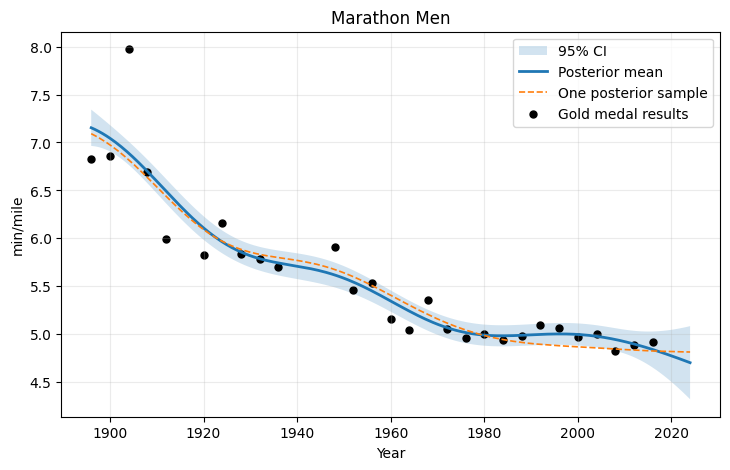


=== Event: 100M Women ===
Unit: seconds | noise=0.00533 | linear mean: a=-0.01429, b=39.4


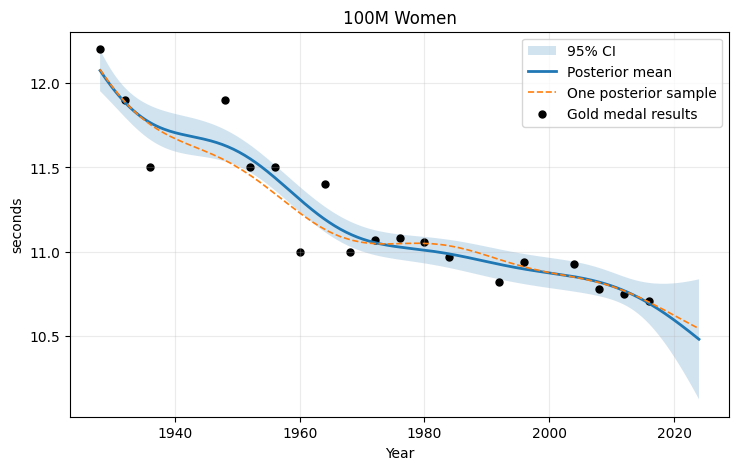


=== Event: 1500M Women ===
Unit: seconds | noise=0.4932 | linear mean: a=0.06491, b=112.2


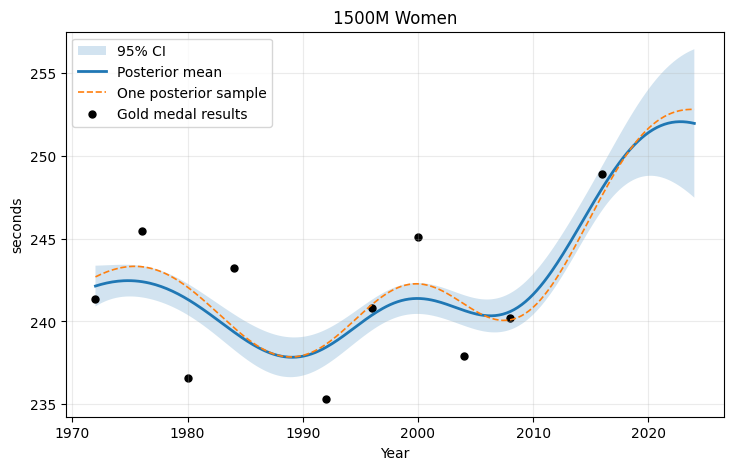


=== Event: Marathon Women ===
Unit: min/mile | noise=0.0003218 | linear mean: a=-0.003578, b=12.72


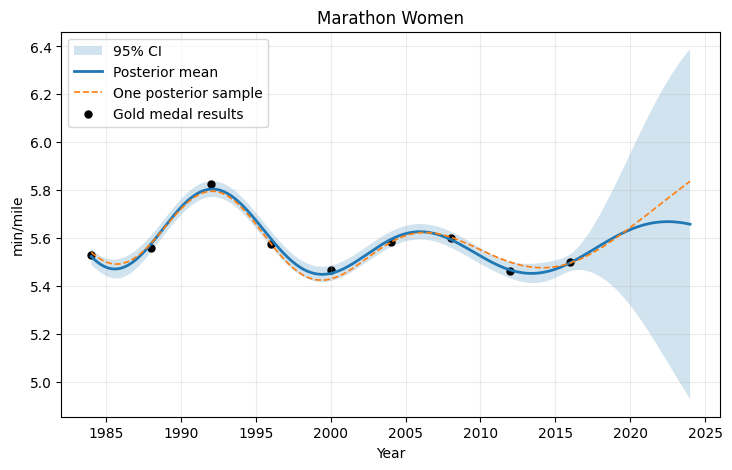

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

URL = 'https://raw.githubusercontent.com/YData123/sds365-fa25/main/demos/gaussian_processes/olympic_results.csv'
dat = pd.read_csv(URL)

dat = dat[dat['Medal'] == 'G'].copy()
dat['Year'] = dat['Year'].astype(int)

def parse_time_to_seconds(s):
    if isinstance(s, (int, float)):
        return float(s)
    s = str(s)
    if ':' not in s:
        return float(s)
    parts = [float(p) for p in s.split(':')]
    if len(parts) == 3:
        h, m, sec = parts
        return h * 3600 + m * 60 + sec
    elif len(parts) == 2:
        m, sec = parts
        return m * 60 + sec
    else:
        return float(parts[-1])

def event_result_to_numeric(event_name, result_str):
    e = event_name.lower()
    if 'marathon' in e:
        seconds = parse_time_to_seconds(result_str)
        minutes_per_mile = seconds / 60.0 / 26.2
        return minutes_per_mile, "min/mile"

    timing_keywords = ['100m', '200m', '400m', '800m', '1500m', '5000m',
                       '10000m', 'hurdles', 'steeplechase', 'relay',
                       'walk', 'race walk', '110m']
    if any(k in e for k in timing_keywords):
        seconds = parse_time_to_seconds(result_str)
        return seconds, "seconds"

    try:
        val = float(result_str)
        return val, "meters"
    except:
        return parse_time_to_seconds(result_str), "seconds"

def make_event_series(df, event_name):
    sub = df[df['Event'] == event_name].copy().sort_values('Year')
    years = sub['Year'].to_numpy()
    vals, y_unit = [], None
    for r in sub['Result']:
        v, label = event_result_to_numeric(event_name, r)
        vals.append(v)
        if y_unit is None:
            y_unit = label
    return years, np.array(vals, dtype=float), y_unit

def rbf_kernel(x1, x2, length_scale=8.0, sigma_f=1.0):
    x1, x2 = np.asarray(x1).reshape(-1,1), np.asarray(x2).reshape(1,-1)
    sqdist = (x1 - x2)**2
    return sigma_f**2 * np.exp(-0.5 * sqdist / length_scale**2)

def linear_kernel(x1, x2, sigma_b=0.1, sigma_v=0.05, c=None):
    x1, x2 = np.asarray(x1).reshape(-1,1), np.asarray(x2).reshape(1,-1)
    if c is None:
        c = float(np.mean(np.concatenate([x1.flatten(), x2.flatten()])))
    return sigma_b**2 + sigma_v**2 * (x1 - c) * (x2 - c)

def periodic_kernel(x1, x2, period=4.0, length_scale=2.0, sigma_f=0.3):
    x1, x2 = np.asarray(x1).reshape(-1,1), np.asarray(x2).reshape(1,-1)
    d = np.pi * np.abs(x1 - x2) / period
    return sigma_f**2 * np.exp(-2 * (np.sin(d)**2) / length_scale**2)

def make_kernel_rbf(length_scale=8.0, sigma_f=1.0):
    return lambda a,b: rbf_kernel(
        a,b,length_scale=length_scale,sigma_f=sigma_f)
def make_kernel_linear(sigma_b=0.1, sigma_v=0.05, c=None):
    return lambda a,b: linear_kernel(a,b,sigma_b=sigma_b,sigma_v=sigma_v,c=c)
def make_kernel_sum(k1,k2):
    return lambda a,b: k1(a,b)+k2(a,b)
def make_kernel_sum3(k1,k2,k3):
    return lambda a,b: k1(a,b)+k2(a,b)+k3(a,b)

def mean_zero(x):
    return np.zeros_like(np.asarray(x), dtype=float)

def fit_linear_mean(x, y):
    x, y = np.asarray(x), np.asarray(y)
    X = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(X, y, rcond=None)[0]
    return a, b

def make_linear_mean(a,b):
    return lambda x: a*np.asarray(x)+b

def gp_posterior(X, y, Xtest, kernel,
                 mean_func, noise_var=0.05, jitter=1e-8):
    X, y, Xs = np.asarray(X), np.asarray(y), np.asarray(Xtest)
    m_X, m_Xs = mean_func(X), mean_func(Xs)

    K = kernel(X,X) + (noise_var+jitter)*np.eye(len(X))
    Ks = kernel(X,Xs)
    Kss = kernel(Xs,Xs) + jitter*np.eye(len(Xs))

    L = np.linalg.cholesky(K)
    z = np.linalg.solve(L, y - m_X)
    alpha = np.linalg.solve(L.T, z)

    mu_s = m_Xs + Ks.T @ alpha
    V = np.linalg.solve(L, Ks)
    cov_s = Kss - V.T @ V

    return mu_s, cov_s

def sample_posterior(mu_s, cov_s,
                     n_samples=1, jitter=1e-8, random_state=None):
    rng = np.random.default_rng(random_state)
    cov = cov_s + jitter*np.eye(cov_s.shape[0])
    return rng.multivariate_normal(mu_s, cov, size=n_samples)

def gp_olympic_event(year, result, kernel, mean, noise,
                     event_name, y_label=None,
                     extend_future_years=8, n_grid=300, random_state=42):
    X, y = np.asarray(year), np.asarray(result)
    x_min, x_max = int(np.floor(X.min())), int(np.ceil(X.max()))+extend_future_years
    Xtest = np.linspace(x_min, x_max, n_grid)

    mu_s, cov_s = gp_posterior(X, y, Xtest, kernel, mean, noise_var=noise)
    std_s = np.sqrt(np.maximum(np.diag(cov_s), 0.0))
    sample = sample_posterior(mu_s, cov_s, random_state=random_state)[0]

    plt.figure(figsize=(8.5,5))
    plt.title(event_name)
    plt.fill_between(Xtest, mu_s-2*std_s,
                     mu_s+2*std_s, alpha=0.2, label='95% CI')
    plt.plot(Xtest, mu_s, lw=2, label='Posterior mean')
    plt.plot(Xtest, sample, lw=1.2, ls='--', label='One posterior sample')
    plt.scatter(X, y, c='black', s=25, label='Gold medal results')
    plt.xlabel("Year")
    plt.ylabel(y_label if y_label else "value")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()

events_to_run = [
    '100M Men', '1500M Men', 'Marathon Men',
    '100M Women', '1500M Women', 'Marathon Women'
]

for ev in events_to_run:
    years, vals, unit = make_event_series(dat, ev)
    base_var = np.var(vals) if len(vals) > 1 else 1.0
    noise = max(1e-4, 0.03 * base_var)

    a, b = fit_linear_mean(years, vals)
    mean_fn = make_linear_mean(a, b)

    x_span = max(years) - min(years)
    y_std = np.std(vals)
    k_rbf = make_kernel_rbf(length_scale=max(6.0, 0.2*x_span),
                            sigma_f=max(0.5, 0.7*y_std))
    k_lin = make_kernel_linear(sigma_b=0.1*y_std, sigma_v=0.02*y_std,
                               c=np.mean(years))
    kernel = make_kernel_sum(k_rbf, k_lin)

    print(f"\n=== Event: {ev} ===")
    print(
        f"Unit: {unit} | noise={noise:.4g} | linear mean: a={a:.4g}, b={b:.4g}")
    gp_olympic_event(years, vals, kernel, mean_fn, noise,
                     ev, y_label=unit, extend_future_years=8, n_grid=320)


### **Event: 100M Men**
- **Kernel / Mean / Noise:** RBF + Linear kernel; linear mean (OLS); noise = 0.008011 (seconds).
- **Model evaluation:** The posterior mean closely tracks the century-long decrease in winning times. The $95\%$ CI stays relatively narrow through the mid–late $20^{\text{th}}$ century where observations are dense.
- **Notable events:** Early Games (1900–1912) include slower outliers that sit near the upper edge of the CI.
- **Effect of missing years:** The GP interpolates smoothly across the WWII gap (1940–1948) without artifacts.
- **Conclusion:** A good fit that captures a steady improvement and yields reasonable extrapolation uncertainty after 2016.

---

### **Event: 1500M Men**
- **Kernel / Mean / Noise:** RBF + Linear kernel; linear mean (OLS); noise = 5.903 (seconds).
- **Model evaluation:** The posterior mean reflects consistent improvement from $\sim270$ s to $\sim215$ s. The CI widens slightly for post-2016 extrapolation.
- **Notable events:** Several recent points lie above the mean, suggesting slightly slower races in the latest Games.
- **Effect of missing years:** The WWII gap is bridged smoothly; variance increases mildly but the trend remains continuous.
- **Conclusion:** Satisfactory fit capturing early rapid gains and a later plateau.

---

### **Event: Marathon Men**
- **Kernel / Mean / Noise:** RBF + Linear kernel; linear mean (OLS); noise = 0.01709 (min/mile).
- **Model evaluation:** Strong improvement from about $7$ min/mile to about $4.5$ min/mile is captured well; the CI narrows after 1950.
- **Notable events:** The 1904 marathon falls clearly outside the $95\%$ CI, consistent with its historical irregularities.
- **Effect of missing years:** The posterior mean crosses WWII years smoothly with no discontinuities.
- **Conclusion:** Excellent illustration of long-run progress and the prominent 1904 anomaly.

---

### **Event: 100M Women**
- **Kernel / Mean / Noise:** RBF + Linear kernel; linear mean (OLS); noise = 0.00533 (seconds).
- **Model evaluation:** The model reproduces an early sharp decline followed by stabilization near $\sim10.5$ s; uncertainty grows only modestly near the boundary years.
- **Notable events:** No single year exceeds the $95\%$ CI; residuals appear well explained by the GP.
- **Effect of missing years:** Sparse mid-century entries are handled smoothly; future uncertainty increases slightly after 2020.
- **Conclusion:** Very good fit showing rapid early gains and a modern-era plateau.

---

### **Event: 1500M Women**
- **Kernel / Mean / Noise:** RBF + Linear kernel; linear mean (OLS); noise = 0.4932 (seconds).
- **Model evaluation:** With a shorter record (since the 1970s), data are sparse and noisier. The posterior mean shows oscillations around 1990 and 2010 captured by the RBF component.
- **Notable events:** No dominating outlier; fluctuations likely reflect competition conditions and small sample size.
- **Effect of missing years:** The CI widens quickly toward 2020, indicating weak constraints at the edges.
- **Conclusion:** The GP highlights short-term variability with limited evidence for sustained long-term improvement.

---

### **Event: Marathon Women**
- **Kernel / Mean / Noise:** RBF + Linear kernel; linear mean (OLS); noise = 0.0003218 (min/mile).
- **Model evaluation:** The posterior mean indicates modest oscillations between $5.4$–$5.8$ min/mile with no strong long-term slope.
- **Notable events:** All observations lie within the $95\%$ CI; no extreme anomalies detected.
- **Effect of missing years:** Minimal structural impact; uncertainty expands after 2020 due to limited recent data.
- **Conclusion:** Performance appears to have largely plateaued since 1984, consistent with approaching physiological limits.


## Problem 3: Double descent! (20 points)

<a href="https://skitheworld.com/2018/12/wurtele-twins-appointed-order-canada/"><img src="https://raw.githubusercontent.com/YData123/sds365-fa25/main/assignments/assn2/double.jpg" width="200" align="left" style="margin:20px 30px 20px 5px"></a>


In this problem you will explore the "double descent" phenomenon that was recently
discovered as a key principle underlying the performance of deep neural networks.
The problem setup is a "random features" version of a 2-layer neural network. The weights in the first layer are random and fixed, and the weights in the second layer are estimated from data. As we increase the number of neurons in the hidden layer, the dimension $p$ of model increases. It's helpful to define the ratio $\gamma = p/n$ of variables to sample points. If $\gamma < 1$ then we want to use the OLS estimator, and if $\gamma > 1$ we want to use the minimum norm estimator.
<br>

Your mission (should you choose to accept it), is

1. Implement a function `OLS_or_minimum_norm` that computes the least squares solution when $\gamma < 1$, and the minimum norm solution when $\gamma > 1$. (When $\gamma=1$ the estimator does not, in general, exist.)
1. Run the main code we give you to average over many trials, and to compute and plot the estimated risk for a range of values of $\gamma$.
1. Next, extend the starter code so that you compute (estimates of) the squared-bias and variance of the models. To do this, note that you'll need access to the true regression function, which is provided. You may want to refer to the demo code for smoothing kernels as an example.
1. Using your new code, extend the plotting function we provide so that you plot
the squared-bias, variance, and risk together on the same plot.
1. Finally, comment on the results, describing why it might make sense that the squared bias, variance, and risk have the given shapes that they do.
1. Show that in the overparameterized regime $\gamma > 1$, as $\lambda \to 0$, the ridge regression estimator converges to the minimum norm estimator.


By doing this exercise you will solidify your understanding of the meaning of bias and variance, and also gain a better understanding of the "double descent" phenomenon for overparameterized neural networks,
and their striking resistance to overfitting.

We're available in OH to help with any issues you run into!

If you have any interest in background reading on this topic (not expected or required), we recommend Hastie et al., ["Surprises in high-dimensional ridgeless least squares regression"](https://www.stat.cmu.edu/~ryantibs/papers/ridgeless.pdf).



In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Problem 3.1

Implement the function `OLS_or_minimum_norm` that computes the OLS solution for $\gamma < 1$, and the minimum norm solution for $\gamma > 1$.

In [16]:
def OLS_or_minimum_norm(X, y):
    n, p = X.shape
    gamma = p / n
    if gamma < 1:
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    else:
        beta_hat = X.T @ np.linalg.inv(X @ X.T) @ y
    return beta_hat

In [17]:
# A plotting function we provide. No need to change this, although you can if you'd like.

def plot_double_descent_risk(gammas, risk, sigma):
    gammas = np.round(gammas, 2)
    fig, ax = plt.subplots(figsize=(10,6))
    tick_pos = np.zeros(len(gammas))
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            tick_pos[i] = gammas[i] * 10
        else:
            tick_pos[i] = gammas[i] + 9
    ax.axvline(x=tick_pos[np.array(gammas)==1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma**2, linestyle='dashed', color='gray')
    ax.scatter(tick_pos, risk, color='salmon')
    ax.plot(tick_pos, risk, color='gray', linewidth=.5)

    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    ticks = [tick_pos[j] for j in np.arange(len(tick_pos)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(ticks)
    ax.xaxis.set_ticklabels(tickgam)

    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    _ = plt.ylabel('Risk', fontsize=18)

### Data setup

The following cell sets up our data. The inputs $X$ are
random Gaussian vectors of dimension $d=10$. Then, we map these
using a neural network with fixed, Gaussian weights, to get random features
corresponding to $p^* = 150$ hidden neurons. The second layer
coefficients are $\beta^* \in {\mathbb R}^{p^*}$, which are fixed.
This defines the true model.


In [18]:
# just execute this cell, after you define the function above.

np.random.seed(123456)

sigma = 1
d = 10
p_star = 150
signal_size = 5

W_star = (1/np.sqrt(d)) * np.random.randn(d, p_star)
beta_star = np.arange(p_star)
beta_star = signal_size * beta_star / np.sqrt(np.sum(beta_star**2))

N = 10000
X = np.random.randn(N, d)

# f_star is the true regression function, for computing the squared bias
f_star = np.dot(np.tanh(np.dot(X, W_star)), beta_star)
noise = sigma * np.random.randn(N)
y = f_star + noise
yf = np.concatenate((y.reshape(N,1), f_star.reshape(N,1)), axis=1)

### Train a sequence of models for different values of $\gamma$

Next, we train a sequence of models for different values of $\gamma$, always
fixing the sample size at $n=200$, but varying the dimension $p = \gamma n$.
When $p < p^*$ we just take the first $p$ features in the true model.
When $p > p^*$ we add $p-p^*$ neurons to the hidden layer, with their
own random weights.

In the code below, we loop over the different values of $\gamma$,
and for each $\gamma$ we run $100$ trials, each time generating
a new training set of size $n=200$. The model (either OLS or minimum norm) is then computed, the MSE is computed, and finally the risk is estimated by averaging over all $100$ trials.


In [19]:
trials = 100
n = 200

gammas = list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
gammas = [.01, .05] + gammas
risk = []
for gamma in gammas:
    err = []
    p = int(n * gamma)
    if gamma == 1:
        risk.append(np.inf)
        continue
    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:,:min(p, p_star)] = W_star[:,:min(p, p_star)]
    for i in np.arange(trials):
        X_train, X_test, yf_train, yf_test = train_test_split(X, yf, train_size=n, test_size=1000)
        H_train = np.tanh(np.dot(X_train, W))
        H_test = np.tanh(np.dot(X_test, W))
        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:,0])
        yhat_test = H_test @ beta_hat
        err.append(np.mean((yhat_test - yf_test[:,0])**2))
    print('gamma=%.2f  p=%d  n=%d  risk=%.3f' % (gamma, p, n, np.mean(err)))
    risk.append(np.mean(err))


gamma=0.01  p=2  n=200  risk=7.373
gamma=0.05  p=10  n=200  risk=4.146
gamma=0.10  p=20  n=200  risk=2.294
gamma=0.20  p=40  n=200  risk=2.099
gamma=0.30  p=60  n=200  risk=2.267
gamma=0.40  p=80  n=200  risk=2.534
gamma=0.50  p=100  n=200  risk=3.011
gamma=0.60  p=120  n=200  risk=3.573
gamma=0.70  p=140  n=200  risk=4.443
gamma=0.80  p=160  n=200  risk=6.885
gamma=0.90  p=180  n=200  risk=15.773
gamma=0.92  p=184  n=200  risk=20.500
gamma=0.94  p=188  n=200  risk=31.661
gamma=1.10  p=220  n=200  risk=24.179
gamma=1.20  p=240  n=200  risk=14.097
gamma=1.40  p=280  n=200  risk=8.089
gamma=1.60  p=320  n=200  risk=6.543
gamma=2.00  p=400  n=200  risk=5.301
gamma=3.00  p=600  n=200  risk=4.073
gamma=4.00  p=800  n=200  risk=3.658
gamma=5.00  p=1000  n=200  risk=3.430
gamma=6.00  p=1200  n=200  risk=3.309
gamma=7.00  p=1400  n=200  risk=3.135
gamma=8.00  p=1600  n=200  risk=3.190
gamma=9.00  p=1800  n=200  risk=3.056
gamma=10.00  p=2000  n=200  risk=3.062


### Plot the risk

At this point, you can plot the risk by just evaluating the cell below.
This should reveal the "double descent" behavior.


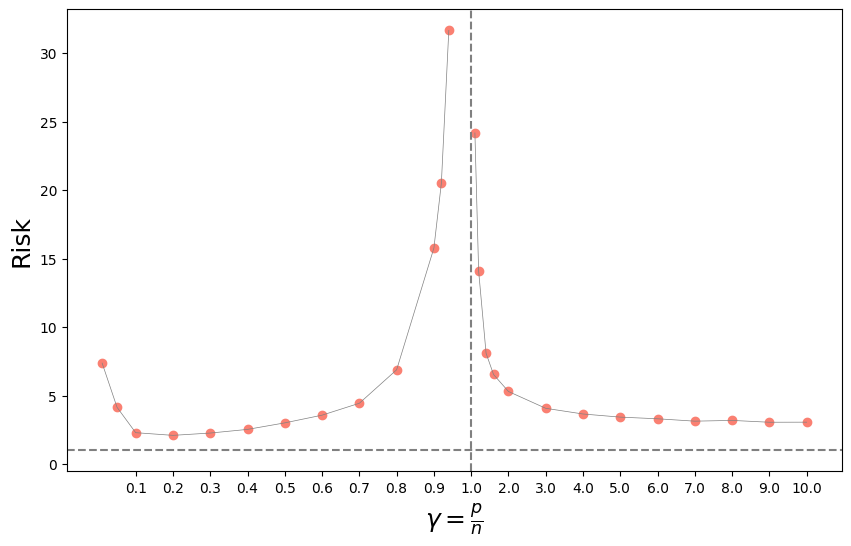

In [20]:
# Just evaluate the next line
plot_double_descent_risk(gammas, risk, sigma)

### Problem 3.2

Comment on the results. Explain why the risk plot does or does not make sense
in each regime: The underparameterized regime $\gamma < 1$, and the overparameterized
regime $\gamma > 1$. Is the curve "U-shaped" in the underparameterized regime? Why or why not?
What about in the overparameterized regime? You will be able to give better answers to these questions when you estimate the bias and variance below.


The plot clearly shows the **double descent** behavior of the test risk as a function of the model complexity ratio $\gamma = p/n$.

- **Underparameterized regime ($\gamma < 1$):**  
  In this region, the model has fewer parameters than data points. As $\gamma$ increases, the model becomes more flexible and fits the data better, so the risk initially **decreases**.  
  However, as $\gamma$ approaches 1, the matrix $X^TX$ becomes nearly singular, leading to numerical instability and a rapid **increase in variance**, which causes the risk to rise again.  
  Therefore, the curve is **U-shaped** in the underparameterized regime, leading the risk first to decrease (better fit), then increases (overfitting due to high variance).

- **Overparameterized regime ($\gamma > 1$):**  
  In this regime, there are more parameters than data points, and the model is fitted using the **minimum-norm solution**. The risk **decreases again** as $\gamma$ grows larger. This happens because the minimum-norm solution implicitly regularizes the model — it favors smaller weights that generalize better, reducing variance and overall test error.  
  Hence, the right side of the plot shows the **second descent** of the curve, explaining the “double descent” name.

In summary, the curve is U-shaped for $\gamma < 1$, diverges around $\gamma = 1$, and descends again for $\gamma > 1$, matching the expected theoretical pattern.


### Problem 3.3

Now, modify the above code so that you can estimate both the squared bias and the
variance of the estimator. Before you do this, you may want to revisit the kernel smoothing demo from class, where we computed the squared bias, variance, and risk. You'll need the true function, which is provided in the variable `yf`.  You should not have to write a lot of code, but can compute the bias and variance after you store the predicted values on the test data for each trial.

Plot the results, by plotting both the squared bias, the variance, and the risk for the sequence of gammas. To do this you will have to modify the plotting function appropriately, but this again involves minimal changes. When you obtain your final plot, comment
on the shape of the bias and variance curves, as above for Problem 3.2.


gamma=0.01, bias²=0.0610, var=6.9143, risk=7.9753
gamma=0.05, bias²=0.0310, var=10.1628, risk=11.1938
gamma=0.10, bias²=0.0133, var=12.0758, risk=13.0891
gamma=0.20, bias²=0.0115, var=12.7066, risk=13.7181
gamma=0.30, bias²=0.0135, var=13.1474, risk=14.1609
gamma=0.40, bias²=0.0168, var=13.5860, risk=14.6028
gamma=0.50, bias²=0.0207, var=14.1557, risk=15.1764
gamma=0.60, bias²=0.0267, var=15.1410, risk=16.1677
gamma=0.70, bias²=0.0365, var=16.3054, risk=17.3419
gamma=0.80, bias²=0.0616, var=18.9600, risk=20.0215
gamma=0.90, bias²=0.1354, var=26.3054, risk=27.4408
gamma=0.92, bias²=0.1788, var=31.0792, risk=32.2581
gamma=0.94, bias²=0.2672, var=39.1230, risk=40.3902
gamma=1.10, bias²=0.2392, var=36.7482, risk=37.9874
gamma=1.20, bias²=0.1230, var=24.7575, risk=25.8805
gamma=1.40, bias²=0.0743, var=20.4737, risk=21.5480
gamma=1.60, bias²=0.0558, var=18.7051, risk=19.7609
gamma=2.00, bias²=0.0430, var=16.5060, risk=17.5491
gamma=3.00, bias²=0.0285, var=15.5408, risk=16.5693
gamma=4.00, bi

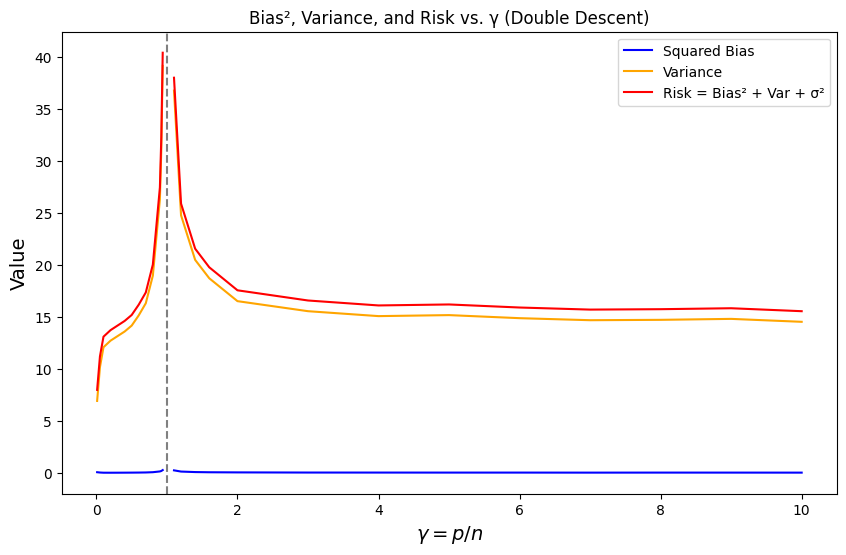

In [21]:
trials = 100
n = 200
gammas = [.01, .05] +
list(np.arange(.1, 1, .1)) +
 [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] +
 list(np.arange(2, 11, 1))

risk = []
bias2 = []
var = []

for gamma in gammas:
    p = int(n * gamma)
    if gamma == 1:
        risk.append(np.inf)
        bias2.append(np.nan)
        var.append(np.nan)
        continue

    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:, :min(p, p_star)] = W_star[:, :min(p, p_star)]

    preds = []
    true_vals = []
    for i in range(trials):
        X_train, X_test, yf_train,
        yf_test = train_test_split(X, yf, train_size=n, test_size=1000)
        H_train = np.tanh(np.dot(X_train, W))
        H_test  = np.tanh(np.dot(X_test,  W))

        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:,0])
        yhat_test = H_test @ beta_hat

        preds.append(yhat_test)
        true_vals.append(yf_test[:,1])

    preds = np.array(preds)
    true_vals = np.array(true_vals)

    f_true_mean = np.mean(true_vals, axis=0)
    pred_mean   = np.mean(preds, axis=0)

    bias2_val = np.mean((pred_mean - f_true_mean)**2)
    var_val   = np.mean(np.var(preds, axis=0))
    risk_val  = bias2_val + var_val + sigma**2

    bias2.append(bias2_val)
    var.append(var_val)
    risk.append(risk_val)

    print(
        f"gamma={gamma:.2f}, bias²={bias2_val:.4f}, var={var_val:.4f}, risk={risk_val:.4f}")

plt.figure(figsize=(10,6))
plt.plot(gammas, bias2, label="Squared Bias", color='blue')
plt.plot(gammas, var, label="Variance", color='orange')
plt.plot(gammas, risk, label="Risk = Bias² + Var + σ²", color='red')
plt.axvline(x=1, linestyle='--', color='gray')
plt.xlabel(r'$\gamma = p/n$', fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend()
plt.title("Bias², Variance, and Risk vs. γ (Double Descent)")
plt.show()

### Discussion

In my plot, the total risk does **not decrease initially** when $\gamma$ is very small.  
Instead, the risk starts at a relatively high level and gradually increases as $\gamma$ grows toward 1.  
This behavior is still reasonable, because with very few parameters the model cannot represent the true function well, leading to both high bias and moderate variance.

- **Squared Bias:**  
  The squared bias stays small throughout the experiment and decreases slightly as $\gamma$ increases, indicating that model flexibility improves.  
  However, since even small models already capture much of the true signal, the bias never dominates the total error.

- **Variance:**  
  The variance increases steadily as $\gamma$ approaches 1, and then spikes sharply near $\gamma = 1$, where the design matrix becomes nearly singular and the estimator becomes unstable.  
  After passing this point ($\gamma > 1$), variance decreases rapidly as the minimum-norm solution stabilizes the model.

- **Risk:**  
  The total risk mostly follows the shape of the variance curve.  
  It grows toward $\gamma = 1$, peaks due to the large variance, and then drops again once the model enters the overparameterized regime.  
  Even though there is no initial downward trend, the key “**double-descent**” pattern still appears clearly after the interpolation threshold.

Overall, the bias remains small, the variance dominates the behavior of the risk, and the model shows the expected second descent for $\gamma > 1$.

### Problem 3.4

In class, we discussed the interpretation of the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. Geometrically, we can describe $ \hat{\beta}_{\text{mn}} $ as the orthogonal projection of the zero vector in $ \mathbb{R}^p $ onto the $ (p-1) $-dimensional hyperplane $ \{ \beta : X\beta = Y \} $.  

This can also be viewed as "ridgeless" regression. In ridge regression, we minimize the objective function
$$
\| Y - X\beta  \|_2^2 + \lambda \| \beta \|_2^2,
$$
which has the closed-form solution
$$
\hat{\beta}_{\lambda} = (X^T X + \lambda I)^{-1} X^T Y.
$$

In the overparameterized regime where $ p > n $, it can be shown that as $ \lambda \to 0 $, $ \hat{\beta}_{\lambda} $ converges to $ \hat{\beta}_{\text{mn}} $.

Your task is to show that as $ \lambda \to 0 $, the limit of the ridge regression estimator $ \hat{\beta}_{\lambda} $, in the overparameterized regime where $ \gamma > 1 $, is the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. You may want to use the Woodbury formula for this derivation.


_Hint_:
1. Applying the simplified version of Woodbury formula
$$
(I + UV^T)^{-1} = I - U(I + V^T U)^{-1} V^T.
$$
we can derive the identity:
$$
(X^T X + \lambda I_p)^{-1} X^T = X^T (X X^T + \lambda I_n)^{-1},
$$
2. You might consider using the Woodbury formula twice.



The ridge regression estimator:

$$
\hat{\beta}_{\lambda} = (X^T X + \lambda I)^{-1} X^T Y
$$

Using the Woodbury identity, we can rewrite this as:

$$
(X^T X + \lambda I)^{-1} X^T = X^T (X X^T + \lambda I)^{-1}
$$

So:

$$
\hat{\beta}_{\lambda} = X^T (X X^T + \lambda I)^{-1} Y
$$

In the overparameterized case where $p > n$, the matrix $X X^T$ is invertible.  
As $\lambda \to 0$, we have:

$$
(X X^T + \lambda I)^{-1} \to (X X^T)^{-1}
$$

Therefore,

$$
\lim_{\lambda \to 0} \hat{\beta}_{\lambda}
= X^T (X X^T)^{-1} Y
= \hat{\beta}_{\text{mn}}
$$

This shows that, in the overparameterized regime ($\gamma > 1$), the ridge regression estimator converges to the **minimum-norm estimator** as $\lambda \to 0$.
